<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cross Validation results of Grid Search
       mean  neighbors
0  0.939865          3
1  0.944430          7
2  0.941916         20
3  0.937748         50
4  0.933646        100
Best params: {'knn__n_neighbors': 7}
Best score: 0.9444296767113507

Results of test data
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1878
           1       0.93      0.94      0.94      1902

    accuracy                           0.94      3780
   macro avg       0.94      0.94      0.94      3780
weighted avg       0.94      0.94      0.94      3780

Specificity 0: 0.94
Specificity 1: 0.93



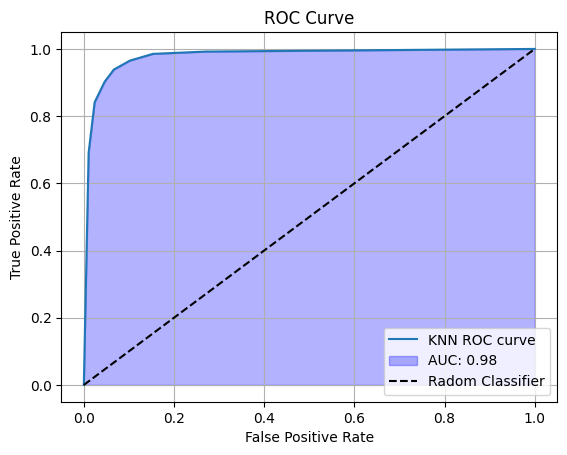

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Carregando o dataset (true/fake tweets)
col_names = ['title', 'tweet', 'type', 'date']
fake_df = pd.read_csv('https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv', names=col_names, header=0)
true_df = pd.read_csv('https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv', names=col_names, header=0)

# Criando a coluna do target
fake_df['target'] = 0
true_df['target'] = 1

# Concatenando os tweets verdadeiros e falsos
all = pd.concat([fake_df, true_df], ignore_index=True)
# Embaralhando os documentos
all = all.sample(frac=1, random_state=42)

# Separando documentos e target
x = all['tweet']
y = all['target']

# Dividindo entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Questão 1 - Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar
# a importância das palavras em um conjunto de documentos

# O Term-Frequency Inverse-Document-Frequency faz com que o cada token tenha um valor baseado na frequência, porém
# aplica penalização caso o token seja frequente em outros documentos, assumindo que possa ser um token sem muita
# relevância (palavras comuns que estão sempre presentes, mas não possuem o sentido principal do texto)

pipeline = Pipeline(steps=[
  # Obtendo uma matriz com os pesos atribuídos pelo TFIDF à cada token por documento
  ('tfidf', TfidfVectorizer()),
  # Transformando em componentes e reduzindo a dimensionalidade
  ('svd', TruncatedSVD(n_components=20, random_state=42)),
  ('knn', KNeighborsClassifier())
])

# Questão 2 - Modelagem de K-Nearest Neighbors (KNN): Criar modelos simples de classificação utilizando a base de dados codificada por
# TF-IDF. Explore diferentes valores para o parâmetro K do KNN e analise seu impacto nos resultados obtidos (através da acurácia do modelo
# para os dados de validação)

# O KNN, assim como o TFIDF e o SVD, foi colocado no pipeline e é usado dentro do Grid Search junto com os parâmetros de grid_params para
# que sejam retornadas as acurácias dos modelos utilizados. Todos os modelos tiveram um bom resultado com os dados de validação e seus scores
# ficaram bem próximos, entre 93% e 94% de acurácia. Pensando em processamento, um número pequeno do hiperparâmetro pode ser o ideal, quando
# os scores estão muito próximos.

grid_params = {
    'knn__n_neighbors': [3, 7, 20, 50, 100]
}

# Questões 3 -  Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

# A validação cruzada faz com que folds sejam criados. Um desses folds é usado para validação e os outros para treino. A acurácia é
# retornada e depois outro fold vai para validação e o da validação vai para treino. Essas etapas são repetidas até todos folds passarem
# serem usados como validação. Usando a validação cruzada para cada hiperparâmetro (n_neighbors neste caso), obteremos o melhor modelo.
# A validação cruzada faz com que o modelo seja menos propenso a overfit, pois treinando com apenas um conjunto de dados, o modelo poderia
# ficar enviesado e não conseguir generalizar para outros tipos de dados. Um bom resultado no treino, nem sempre garante bons resultados com
# dados novos.

# Grid Search fazendo a validaçao cruazada com 5 folds e retornando o melhor hiperparâmetro
grid_search = GridSearchCV(pipeline, grid_params, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
print('Cross Validation results of Grid Search')
results = grid_search.cv_results_
results_df = pd.DataFrame()
results_df['mean'] = results['mean_test_score']
results_df['neighbors'] = results['param_knn__n_neighbors']
print(results_df)
# best result
print(f'Best params: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}', end='\n\n')

# 4 - Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade
# para avaliar os modelos.

# Usando o modelo com melhor hiperparâmetro nos dados de teste (não vistos ainda pelo modelo)
y_pred = grid_search.best_estimator_.predict(x_test)
print('Results of test data')

# Obtendo recall, f1-score, precisão e acurácia com os dados de teste
print(classification_report(y_test, y_pred))
# Otendo especificidade
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity0 = tp/(tp+fn)
specificity1 = tn/(tn+fp)
print(f'Specificity 0: {specificity0:.2f}')
print(f'Specificity 1: {specificity1:.2f}', end='\n\n')

# Gráfico com a curva ROC e o valor da área sob a curva
y_proba = grid_search.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='KNN ROC curve')
plt.fill_between(fpr, tpr, alpha=0.3, color='blue', label=f'AUC: {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Radom Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 5 - Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência do
# classificador criado.

# Temos 94% de precisão para a classe 0 (fake). Isso significa que dos preditos como fake, 94% estavam corretos. Para a classe 1 (true),
# tivemos 93% de precisão.

# O recall (sensibilidade) da classe fake foi de 93%, o que indica que, considerando apenas as amostras que realmente são fake, 93% foram
# classificados corretamente e 7% eram fake mas foram classificados como true. Para a classe true, 6% dos que realmente eram true foram
# classificados com fake.

# A especificidade verifica quantos dos reais negativos foram classificados como negativos. A especificidade de 94% da classe fake significa
# que 6% dos true foram classificados como fake. E a especificidade de 93% da true significa que 7% dos realmente fakes foram classificados
# como true.

# O f1-score usa a média harmônica entre recall e precisão. Como as duas estão altas e muito próximas (93% e 94%), o f1 também é parecido (94%).

# A acurácia é a porcentagem de acertos em relação a todas as predições.

# A curva ROC possui os falsos positivos no eixo x e os verdadeiros positivos no eixo y. Ela ajuda a visualizar o quanto se pode ter de compensação
# entre recall e especificidade ajustando o threshold para classificações binárias. O AUC (área sob a curva) indica numericamente se o modelo tem um
# bom desempenho, assim como a linha da curva ROC. Se ela passar próxima ao valor máximo de y ao mesmo tempo que os valores mínimos do eixo x, significa
# que é um modelo muito bom. Se for parecida com a linha do classificador aleatório, significa que ele tem desempenho igual a um algoritmo aleatório.
# Se for abaixo, é pior do que tal algoritmo.

# Nesse caso o AUC ficou em 0.98. Ou seja, cobriu 98% da área total no gráfico,
# mostrando que o modelo tem boa capacidade de classificação. A curva se
# aproxima de valores altos de y ao mesmo tempo que os baixos de x. Nessa faixa,
# temos poucos falsos positivos e muitos verdadeiros positivos